In [1]:
import torch
torch.no_grad()

import matplotlib.pyplot as plt

plt.style.use('dark_background')

import numpy as np
from tqdm import tqdm
from pdb import set_trace

from dataset import MakeDataLoader
from torch.utils.data.dataloader import default_collate
make_data_loader = MakeDataLoader()
make_data_loader.collate_fn = default_collate
N = len(make_data_loader.dataset)


!!!!!!!!!!

galaxyzoo_data_cropped_nonnormalized.npy and training_solutions_rev1.csv must be placed in google drive under galaxy-generator/data/
the results will be placed there, too.



In [3]:
import time

data_loader = make_data_loader.get_data_loader_full(batch_size=4, shuffle=True)
for image, label in data_loader:
    time.sleep(2)


/home/shackste/galaxy-generator/data/images_training_rev1/439473.jpg tensor(439473.)
/home/shackste/galaxy-generator/data/images_training_rev1/735494.jpg tensor(735494.)
/home/shackste/galaxy-generator/data/images_training_rev1/866448.jpg tensor(866448.)
/home/shackste/galaxy-generator/data/images_training_rev1/702414.jpg tensor(702414.)
/home/shackste/galaxy-generator/data/images_training_rev1/638703.jpg tensor(638703.)
/home/shackste/galaxy-generator/data/images_training_rev1/273213.jpg tensor(273213.)
/home/shackste/galaxy-generator/data/images_training_rev1/325453.jpg tensor(325453.)
/home/shackste/galaxy-generator/data/images_training_rev1/374100.jpg tensor(374100.)
/home/shackste/galaxy-generator/data/images_training_rev1/707079.jpg tensor(707079.)
/home/shackste/galaxy-generator/data/images_training_rev1/469030.jpg tensor(469030.)
/home/shackste/galaxy-generator/data/images_training_rev1/861986.jpg tensor(861986.)
/home/shackste/galaxy-generator/data/images_training_rev1/913098.

KeyboardInterrupt: 

In [3]:
l = ["abc", "def", "ace"]
np.sort(l)

array(['abc', 'ace', 'def'], dtype='<U3')

# sample variance

In [2]:
from loss import get_sample_variance

batch_size = 32*16

batch_size = N

data_loader = make_data_loader.get_data_loader_full(batch_size=batch_size)
variances = [get_sample_variance(labels) for _, labels in tqdm(data_loader)]

100%|██████████| 1/1 [02:34<00:00, 154.24s/it]


full set

In [3]:
variances

[tensor(0.0268)]

batches

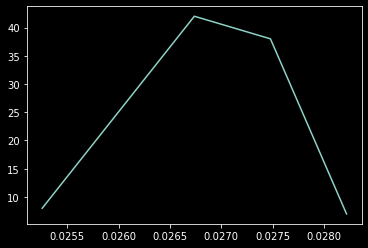

In [10]:
h, x = np.histogram(variances, bins=5)
x_plot = (x[1:] + x[:-1])/2
plt.plot(x_plot, h)

# kinds of galaxies

In [2]:
from labeling import class_groups_indices

# calculate decision tree leaves
def dot_flat(a: torch.Tensor, b:torch.Tensor) -> torch.tensor:
    """ multiply each element in a to each element in b, return results in flat array """
    c = torch.einsum("...i,...j->...ij", a, b)
    c = c.reshape(a.shape[0], a.shape[1]*b.shape[1])
    return c


def label_leaves_likelihood(labels):
    """ compute likelihood for all leaves in the hierarchical label tree """
    def P_group(g):
        return labels[:,class_groups_indices[g]]
    P3 = P_group(3).sum(dim=1)
    P5 = P_group(5).sum(dim=1)
    P6 = P_group(6).sum(dim=1)
    P11 = P_group(11).sum(dim=1)
    P3[P3==0] = 1
    P5[P5==0] = 1
    P6[P6==0] = 1
    P11[P11==0] = 1
    leaves = torch.zeros(len(labels), 1265)
    ## artifact                 1
    leaves[:,0] = P_group(1)[:,2]
    ## round regular            3
    leaves[:,1:4] = P_group(7) * P_group(6)[:,1:2] / P6[:,None]
    ## round odd                21
    leaves[:,4:25] = dot_flat(P_group(7), P_group(8)) / P6[:,None]
    ## disk edge regular        3
    leaves[:,25:28] = P_group(9) * P_group(6)[:,1:2] / P6[:,None]
    ## disk edge odd            21
    leaves[:,28:49] = dot_flat(P_group(9), P_group(8)) / P6[:,None]
    ## disk arms regular        144
    leaves[:,49:193] = dot_flat(dot_flat(dot_flat(P_group(3), P_group(10)), P_group(11)), P_group(5)) * P_group(6)[:,1:2] / (P3 * P11 * P5 * P6)[:,None]
    ## disk arms odd            1008
    leaves[:,193:1201] = dot_flat(dot_flat(dot_flat(dot_flat(P_group(3), P_group(10)), P_group(11)), P_group(5)), P_group(8)) / (P3 * P11 * P5 * P6)[:,None] 
    ## disk no arms regular     8
    leaves[:,1201:1209] = dot_flat(P_group(3), P_group(5)) * P_group(4)[:,1:2] * P_group(6)[:,1:2] / (P3 * P5 * P6)[:,None]
    ## disk no arms odd         56
    leaves[:,1209:1265] = dot_flat(dot_flat(P_group(3), P_group(5)), P_group(8)) * P_group(4)[:,1:2] / (P3 * P5 * P6)[:,None]
    ## total                    1265
    return leaves   


# find and sort for maximum leaves
def find_maximum_index(tensor):
    return leaves.argmax(dim=1)


from labeling import class_groups, label_info
#obtain leave label
def get_leaf_labels(group, label_old):   ### !!!! does work, but doesnt fit leaves obtained above
    if not group:
        return [label_old]
    labels = []
    for i in class_groups[group]:
        label, next_group = label_info[i]
        label = ", ".join([label_old, label]) if label_old else label
        label= get_leave_labels(next_group, label)
        labels.extend(label)
    return labels


# display galaxies within same leaf
def display_galaxy_leaves(leaves, max_leaf, images, columns=6, max_rows=5, start=0, end=1265):
    for l in torch.unique(max_leaf):
        same_leaf, = torch.where(max_leaf == l.item())
        if not l in range(start, end):
            continue
        N_sample = len(same_leaf)
        print(f"\n\n leave {l}: {N_sample} galaxies")
        if N_sample > 1:
            _, sorting = torch.sort(leaves[same_leaf,l], descending=True)
            same_leaf = same_leaf[sorting]
#            print(sorting, leaves[same_leaf,l])
        i = 0
        rows = 0
        for ix in same_leaf:
            if not i:
                fig, axs = plt.subplots(1,columns, figsize=(4*columns, 3), )
            axs[i].imshow(images[ix].transpose(0,2))
            axs[i].set_title(f"{leaves[ix,l]:0.4}")
            i += 1
            if i == columns:
                i = 0
                rows += 1
                plt.show()
            if rows >=max_rows:
                break
        plt.show()
    

In [5]:
display_galaxy_leaves(leaves[:10], max_leaf[:10], images[:10], columns=10, max_rows=1)

NameError: name 'leaves' is not defined

In [3]:
data_loader = make_data_loader.get_data_loader_full(shuffle=False, batch_size=N)
for images, labels in data_loader:
    break
leaves = label_leaves_likelihood(labels)
max_leaf = find_maximum_index(leaves)

In [6]:
def display_leave(leave, rows=20):
    display_galaxy_leaves(leaves, max_leaf, images, columns=10, max_rows=rows, start=leave, end=leave+1)




 leave 138: 72 galaxies


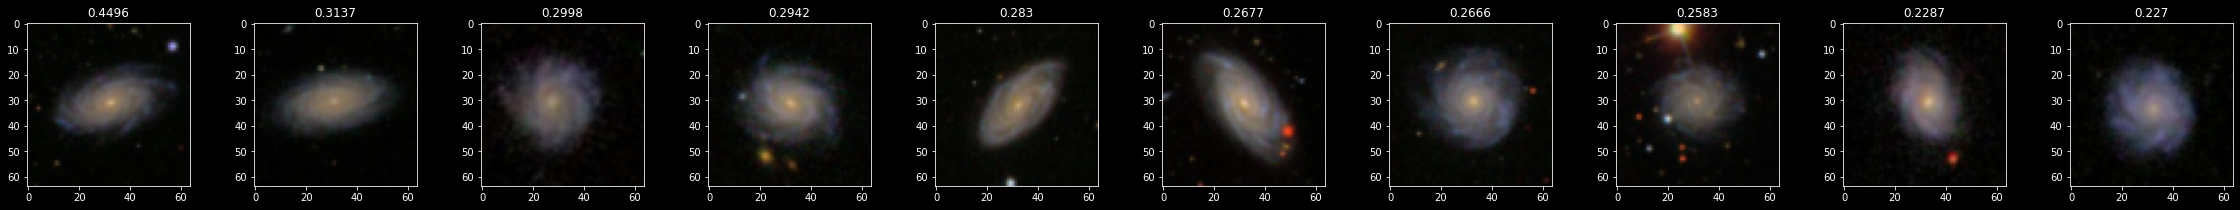

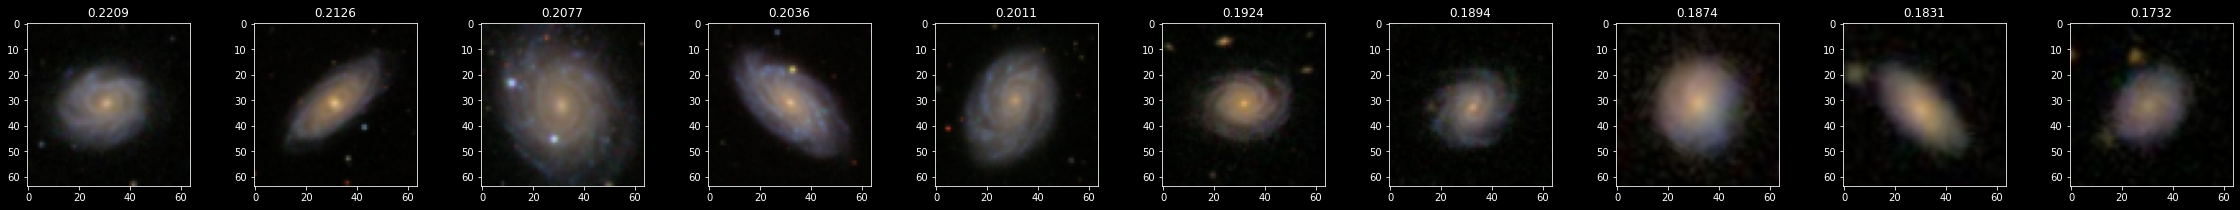

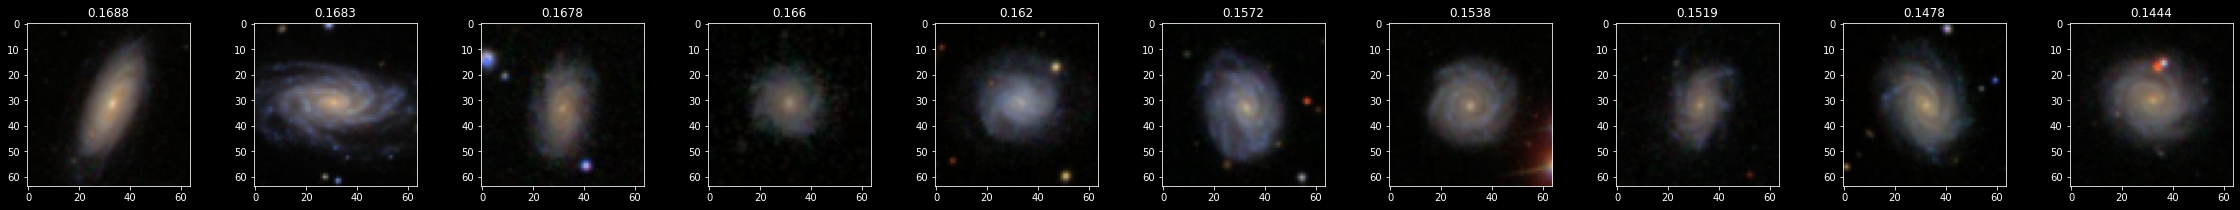

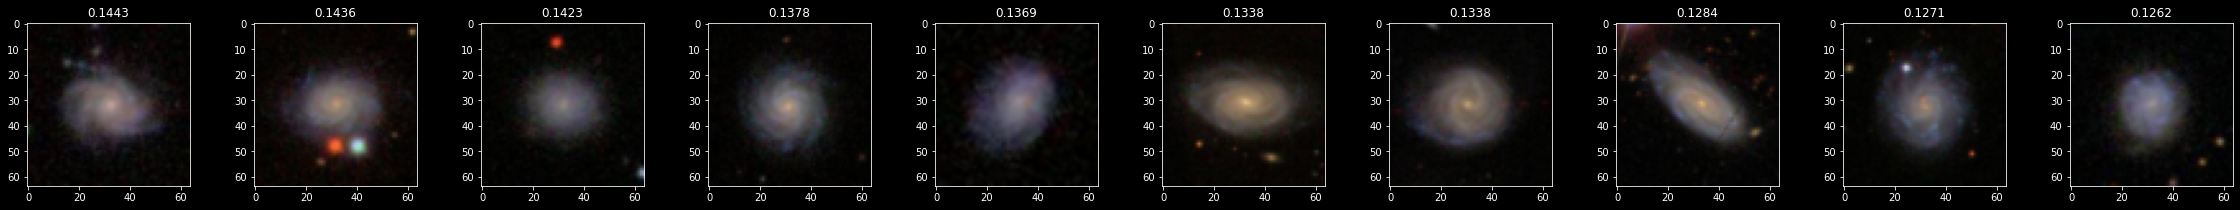

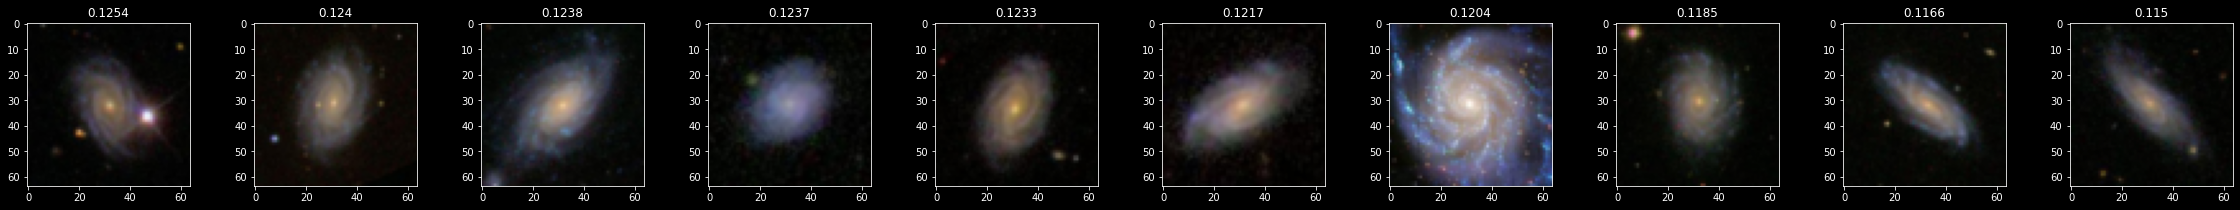

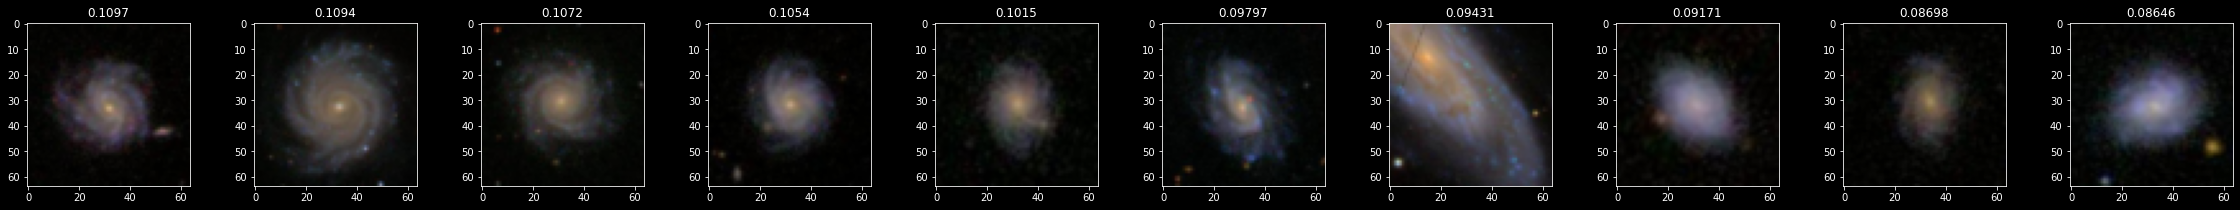

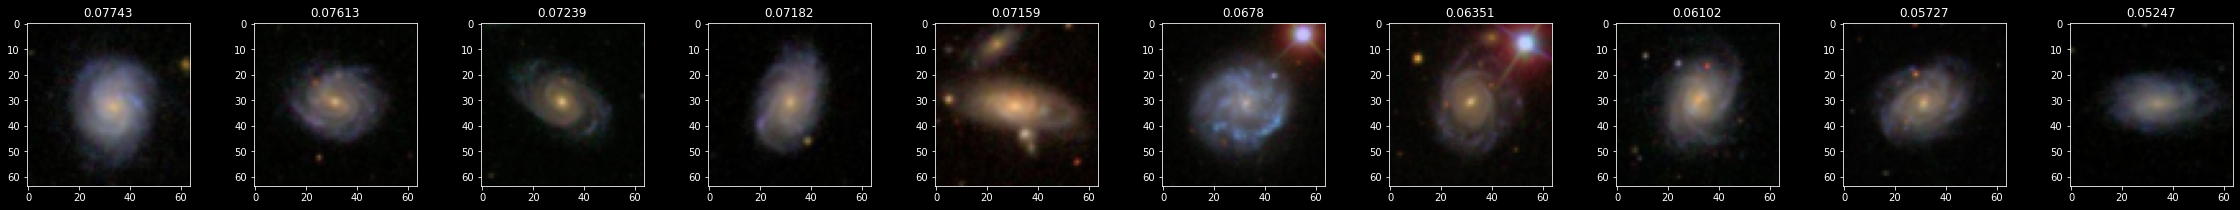

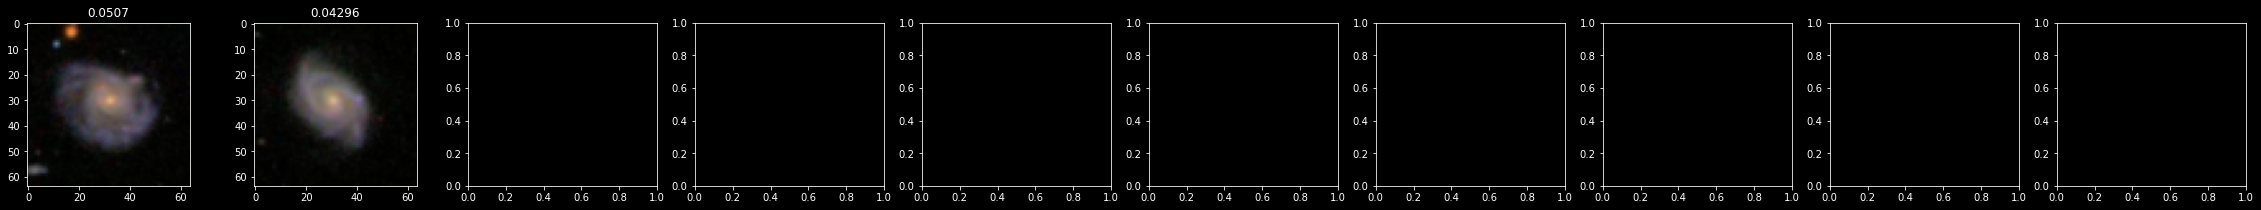

In [21]:
display_leave(138)